# 毕业项目：检测分神司机

In [1]:
%config InlineBackend.figure_format = 'retina'

from urllib.request import urlretrieve
from os.path import isfile, isdir, join, pardir
from IPython.display import SVG, Image
import os, shutil
import random
import glob
import zipfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras import optimizers
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.utils import to_categorical
from keras import regularizers

from keras.applications import resnet50
from keras.applications.resnet50 import ResNet50


import pydot
import cv2
import h5py

d:\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
driver_dataset_folder_path = join(pardir, 'data', 'driver_dataset')
image_train_folder_path = join(pardir, 'data', 'driver_dataset', 'train')
image_test_floder_path = join(pardir, 'data', 'driver_dataset', 'test')
image_valid_folder_path = join(pardir, 'data', 'driver_dataset', 'valid')

resnet50_train_datagen = ImageDataGenerator(
    rotation_range=10.,
    width_shift_range=0.05,
    height_shift_range=0.05,
    preprocessing_function=resnet50.preprocess_input)

resnet50_valid_datagen = ImageDataGenerator(
    preprocessing_function=resnet50.preprocess_input)


resnet50_train_generator = resnet50_train_datagen.flow_from_directory(
    image_train_folder_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical')

resnet50_valid_generator = resnet50_valid_datagen.flow_from_directory(
    image_valid_folder_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False)

Found 20097 images belonging to 10 classes.
Found 2327 images belonging to 10 classes.


### 二、创建模型

In [3]:
model_resnet50 = ResNet50(include_top=False, weights='imagenet')

#print('Print resnet50 model summary:')
#print(model_resnet50.summary())

for i, layer in enumerate(model_resnet50.layers):
    print (i, layer.name)
        
input = Input(shape=(224, 224, 3),name = 'image_input')
 
output_resnet50_conv = model_resnet50(input)
   
x = GlobalAveragePooling2D()(output_resnet50_conv)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax')(x)

0 input_1
1 conv1
2 bn_conv1
3 activation_1
4 max_pooling2d_1
5 res2a_branch2a
6 bn2a_branch2a
7 activation_2
8 res2a_branch2b
9 bn2a_branch2b
10 activation_3
11 res2a_branch2c
12 res2a_branch1
13 bn2a_branch2c
14 bn2a_branch1
15 add_1
16 activation_4
17 res2b_branch2a
18 bn2b_branch2a
19 activation_5
20 res2b_branch2b
21 bn2b_branch2b
22 activation_6
23 res2b_branch2c
24 bn2b_branch2c
25 add_2
26 activation_7
27 res2c_branch2a
28 bn2c_branch2a
29 activation_8
30 res2c_branch2b
31 bn2c_branch2b
32 activation_9
33 res2c_branch2c
34 bn2c_branch2c
35 add_3
36 activation_10
37 res3a_branch2a
38 bn3a_branch2a
39 activation_11
40 res3a_branch2b
41 bn3a_branch2b
42 activation_12
43 res3a_branch2c
44 res3a_branch1
45 bn3a_branch2c
46 bn3a_branch1
47 add_4
48 activation_13
49 res3b_branch2a
50 bn3b_branch2a
51 activation_14
52 res3b_branch2b
53 bn3b_branch2b
54 activation_15
55 res3b_branch2c
56 bn3b_branch2c
57 add_5
58 activation_16
59 res3c_branch2a
60 bn3c_branch2a
61 activation_17
62 res3c

### 三、模型创建
#### 1.锁定ResNet50模型前77层

In [4]:
model_77 = Model(inputs=input, outputs=x)

for i in range(77):
    model_resnet50.layers[i].trainable = False
    
adam = optimizers.Adam(lr=1e-4)
model_77.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [5]:
history_resnet50_finetune_77 = model_77.fit_generator(
    resnet50_train_generator,
    epochs=5,
    validation_data=resnet50_valid_generator)

Epoch 1/5
315/315 [==============================] - 344s 1s/step - loss: 0.2859 - categorical_accuracy: 0.9098 - val_loss: 0.2862 - val_categorical_accuracy: 0.9072
Epoch 2/5
315/315 [==============================] - 334s 1s/step - loss: 0.0350 - categorical_accuracy: 0.9914 - val_loss: 0.3478 - val_categorical_accuracy: 0.9050
Epoch 3/5
315/315 [==============================] - 335s 1s/step - loss: 0.0271 - categorical_accuracy: 0.9908 - val_loss: 0.3352 - val_categorical_accuracy: 0.9162
Epoch 4/5
315/315 [==============================] - 330s 1s/step - loss: 0.0301 - categorical_accuracy: 0.9904 - val_loss: 0.4244 - val_categorical_accuracy: 0.9059
Epoch 5/5
315/315 [==============================] - 329s 1s/step - loss: 0.0307 - categorical_accuracy: 0.9919 - val_loss: 0.2201 - val_categorical_accuracy: 0.9222


In [6]:
model_77.save(join(pardir, 'model', 'resnet50_finetune_77.h5'))
print("Resnet50 model saved.")

Resnet50 model saved.


{'val_loss': [0.28615142552796025, 0.34778769897656425, 0.3352480352638897, 0.42441366714110235, 0.22005714629334527], 'loss': [0.2814511488567936, 0.031155116884829828, 0.02173628996162917, 0.02125946817472047, 0.020167551431776162], 'val_categorical_accuracy': [0.9071766222860355, 0.9050279328840507, 0.9162011172415926, 0.9058874089112341, 0.9222174473827265], 'categorical_accuracy': [0.9126735333631886, 0.9913917500124396, 0.9938796835348559, 0.9935313728417177, 0.9950241329551675]}


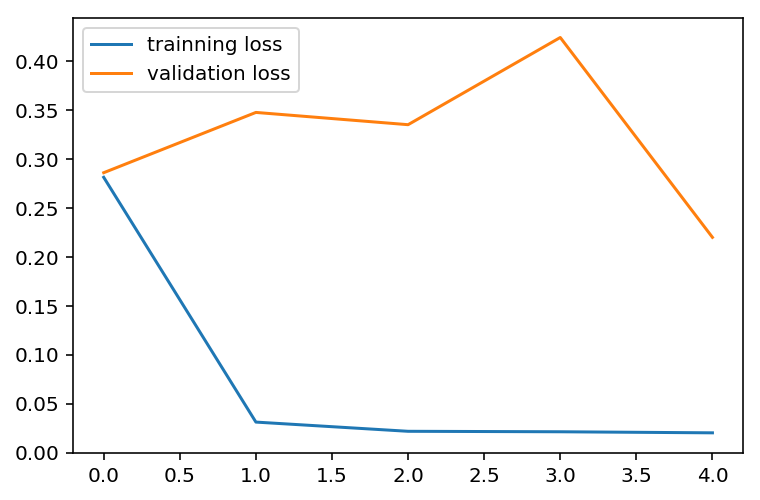

In [7]:
print (history_resnet50_finetune_77.history)
plt.plot (history_resnet50_finetune_77.history['loss'], label="trainning loss")
plt.plot (history_resnet50_finetune_77.history['val_loss'], label="validation loss")
plt.legend()
plt.show()

#### 2.锁定ResNet50模型前139层

In [5]:
model_139 = Model(inputs=input, outputs=x)

for i in range(139):
    model_resnet50.layers[i].trainable = False
    
adam = optimizers.Adam(lr=1e-4)
model_139.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [6]:
history_resnet50_finetune_139 = model_139.fit_generator(
    resnet50_train_generator,
    epochs=5,
    validation_data=resnet50_valid_generator)

Epoch 1/5
315/315 [==============================] - 338s 1s/step - loss: 0.3722 - categorical_accuracy: 0.8807 - val_loss: 0.4876 - val_categorical_accuracy: 0.8784
Epoch 2/5
315/315 [==============================] - 327s 1s/step - loss: 0.0492 - categorical_accuracy: 0.9852 - val_loss: 0.4400 - val_categorical_accuracy: 0.8758
Epoch 3/5
315/315 [==============================] - 325s 1s/step - loss: 0.0306 - categorical_accuracy: 0.9897 - val_loss: 0.4678 - val_categorical_accuracy: 0.8681
Epoch 4/5
315/315 [==============================] - 322s 1s/step - loss: 0.0221 - categorical_accuracy: 0.9945 - val_loss: 0.4684 - val_categorical_accuracy: 0.8741
Epoch 5/5
315/315 [==============================] - 320s 1s/step - loss: 0.0194 - categorical_accuracy: 0.9957 - val_loss: 0.5328 - val_categorical_accuracy: 0.8797


In [7]:
model_139.save(join(pardir, 'model', 'resnet50_finetune_139.h5'))
print("Resnet50 model saved.")

Resnet50 model saved.


{'val_loss': [0.48759643563806215, 0.44003042012619575, 0.4678143137064572, 0.4684200396430713, 0.532795962512967], 'loss': [0.36692305494613503, 0.0435785099796533, 0.02377308339963815, 0.019535705994395892, 0.016835161192502886], 'val_categorical_accuracy': [0.8783841856979843, 0.875805758717852, 0.8680704769706029, 0.8740868070989296, 0.8796733992520862], 'categorical_accuracy': [0.8834154351395731, 0.9883067124446435, 0.9928347514554411, 0.9944767875802358, 0.9956709956709957]}


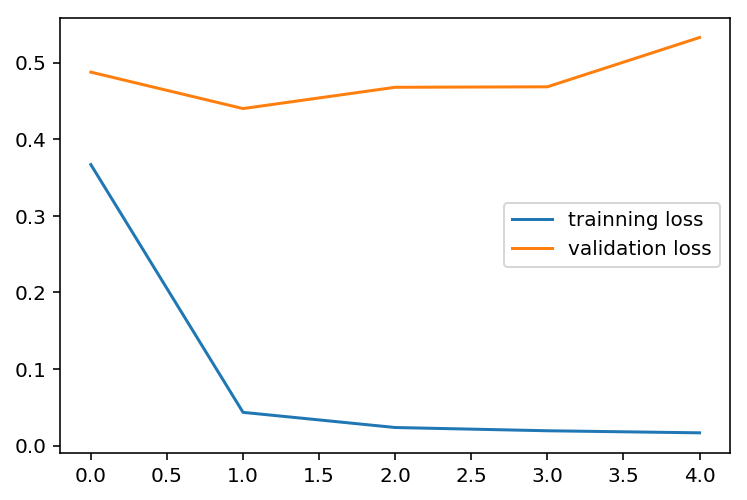

In [8]:
print (history_resnet50_finetune_139.history)
plt.plot (history_resnet50_finetune_139.history['loss'], label="trainning loss")
plt.plot (history_resnet50_finetune_139.history['val_loss'], label="validation loss")
plt.legend()
plt.show()

### 四、模型预测
准备测试集数据

In [9]:
test_image_path = join(driver_dataset_folder_path, 'test')
resnet50_test_datagen = ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)
resnet50_test_generator = resnet50_test_datagen.flow_from_directory(
    test_image_path,
    target_size=(224, 224),
    batch_size=32,
    shuffle=False,
    class_mode='categorical')

Found 79726 images belonging to 1 classes.


#### 1.model_Resnet50_finetune_77
模型加载

In [10]:
model_resnet50_finetune_77 = load_model(join(pardir, 'model', 'resnet50_finetune_77.h5'))
print("Model loaded.")

Model loaded.


结果预测

In [11]:
pred_resnet50_finetune_77 = model_resnet50_finetune_77.predict_generator(resnet50_test_generator, verbose=1)
print(pred_resnet50_finetune_77.shape)

2492/2492 [==============================] - 614s 246ms/step
(79726, 10)


生成kaggle提交文件

In [12]:
image_names = []
for root, dirs, file_name in os.walk(join(test_image_path, '0')):
    image_names.append(file_name)
image_names = np.array(image_names).transpose()

In [13]:
result_resnet50_finetune_77 = np.append(image_names, pred_resnet50_finetune_77, axis = 1)
predict_result_resnet50_finetune_77 = pd.DataFrame(result_resnet50_finetune_77, 
            columns=['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
predict_result_resnet50_finetune_77.to_csv('result_resnet50_finetune_77.csv', index=False)

#### 2.model_Resnet50_finetune_139
模型加载

In [14]:
model_resnet50_finetune_139 = load_model(join(pardir, 'model', 'resnet50_finetune_139.h5'))
print("Model loaded.")

Model loaded.


结果预测

In [15]:
pred_resnet50_finetune_139 = model_resnet50_finetune_139.predict_generator(resnet50_test_generator, verbose=1)
print(pred_resnet50_finetune_139.shape)

2492/2492 [==============================] - 617s 247ms/step
(79726, 10)


生成kaggle提交文件

In [16]:
image_names = []
for root, dirs, file_name in os.walk(join(test_image_path, '0')):
    image_names.append(file_name)
image_names = np.array(image_names).transpose()

In [17]:
result_resnet50_finetune_139 = np.append(image_names, pred_resnet50_finetune_139, axis = 1)
predict_result_resnet50_finetune_139 = pd.DataFrame(result_resnet50_finetune_139, 
            columns=['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
predict_result_resnet50_finetune_139.to_csv('result_resnet50_finetune_139.csv', index=False)